# Pobieranie danych z kaggle


In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dominikebrowski","key":"5806421d00eadc68d024db54baee686d"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.04G/2.04G [00:26<00:00, 194MB/s]
100% 2.04G/2.04G [00:26<00:00, 82.9MB/s]


In [4]:
!pip install optuna
import os
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from collections import Counter
import numpy as np
from torch.utils.data import Subset
import pickle


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.7 MB/s eta 0:00:00


Przygotowanie tranformacji i augumetancji danych

In [5]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(degrees = (-30,30)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

Ładowanie danych

In [6]:
data_dir = '/content/plantvillage dataset/segmented'

dataset = ImageFolder(data_dir)
dataset_transformed = ImageFolder(data_dir, transform = transform)


Przygotowanie Cross Validation

In [7]:
from sklearn.model_selection import KFold
folds = 5
kf = KFold(n_splits = folds, shuffle = True, random_state = 0)


EDA

Ilość klas

In [8]:
len(dataset.classes)


38

Nazwy klas

In [9]:
dataset.classes

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

Ilość obrazów danej klasy

In [10]:
for category_index, count in Counter(dataset.targets).items():
  category_name = dataset.classes[category_index]
  print(f'Kategoria: {category_name}, liczba obrazów: {count}')

Kategoria: Apple___Apple_scab, liczba obrazów: 630
Kategoria: Apple___Black_rot, liczba obrazów: 621
Kategoria: Apple___Cedar_apple_rust, liczba obrazów: 275
Kategoria: Apple___healthy, liczba obrazów: 1645
Kategoria: Blueberry___healthy, liczba obrazów: 1502
Kategoria: Cherry_(including_sour)___Powdery_mildew, liczba obrazów: 1052
Kategoria: Cherry_(including_sour)___healthy, liczba obrazów: 854
Kategoria: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot, liczba obrazów: 513
Kategoria: Corn_(maize)___Common_rust_, liczba obrazów: 1192
Kategoria: Corn_(maize)___Northern_Leaf_Blight, liczba obrazów: 985
Kategoria: Corn_(maize)___healthy, liczba obrazów: 1162
Kategoria: Grape___Black_rot, liczba obrazów: 1180
Kategoria: Grape___Esca_(Black_Measles), liczba obrazów: 1384
Kategoria: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), liczba obrazów: 1076
Kategoria: Grape___healthy, liczba obrazów: 423
Kategoria: Orange___Haunglongbing_(Citrus_greening), liczba obrazów: 5507
Kategoria: Peach___Ba

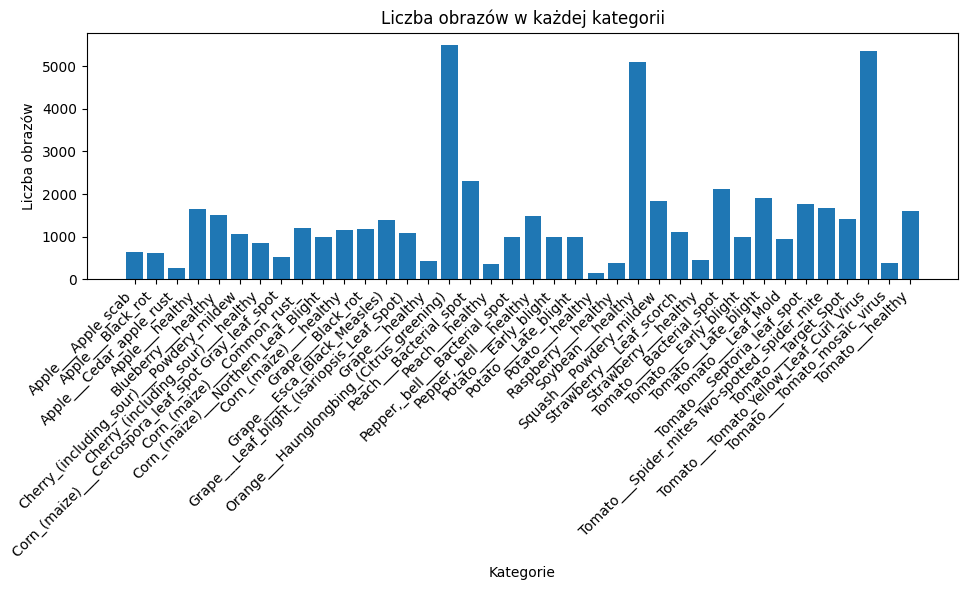

In [11]:
plt.figure(figsize=(10, 6))
plt.bar(dataset.classes, Counter(dataset.targets).values())
plt.xlabel('Kategorie')
plt.ylabel('Liczba obrazów')
plt.title('Liczba obrazów w każdej kategorii')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

Przykładowe obrazy

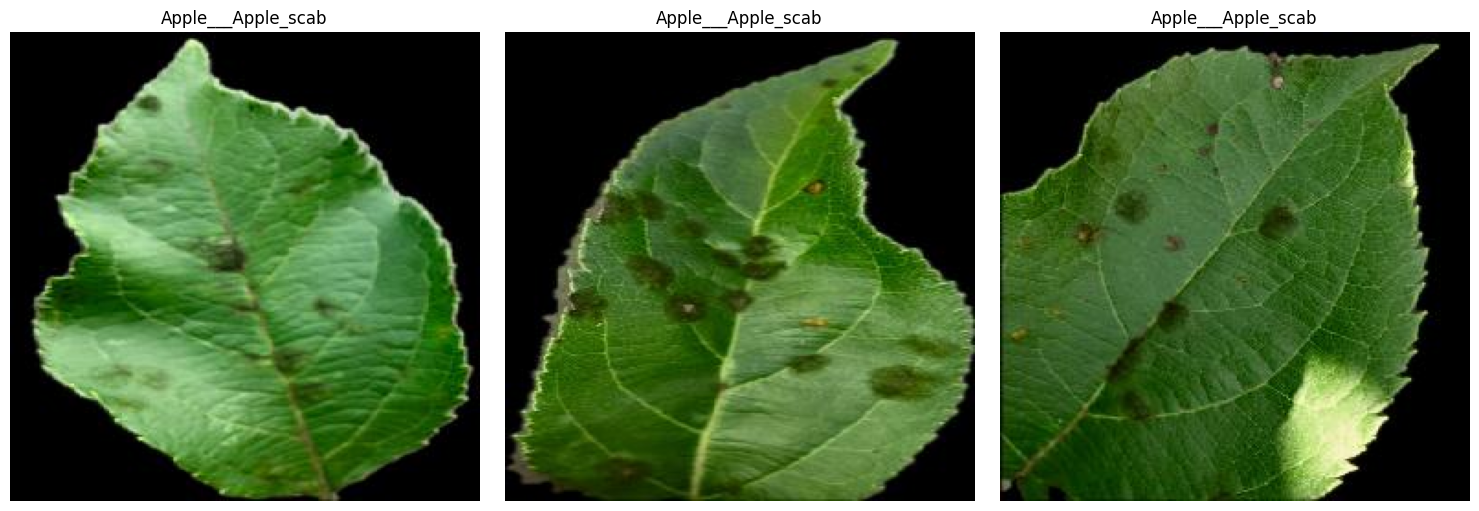

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    img, label = dataset[i]
    axes[i].imshow(img)
    axes[i].set_title(dataset.classes[label])
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Kilka przykładowych obrazów po augumentacji

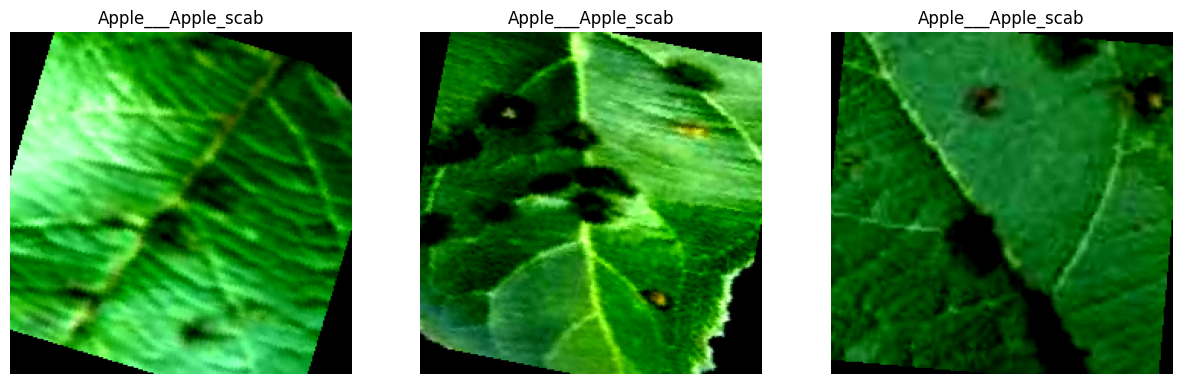

In [13]:
import torchvision


def show_image(ax, image, label):
    image = image / 2 + 0.5  # Zgodnie ze wzorem na odwrócenie normalizacji
    tensor_to_numpy = image.numpy()
    transposed_image = np.transpose(tensor_to_numpy, (1, 2, 0))  # Zmiana kolejności osi z (C, H, W) na (Height, Width, Channels)
    ax.imshow(transposed_image)
    ax.set_title(label)
    ax.axis('off')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    image, label = dataset_transformed[i]  # Pobierz obraz i etykietę
    show_image(axes[i], image, dataset_transformed.classes[label])




Przygotowanie modelu pod fine tuning
Wybrany model to ResNet50

In [14]:
import torch
from torchvision import models
import torch.nn as nn

model = models.resnet18(pretrained=True)

#Mrożenie warstw
for parameters in model.parameters():
  parameters.requires_grad = False

#Odmrożenie ostatnich warstw
for parameters in model.layer4.parameters():
  parameters.requires_grad = True


features_numbers = model.fc.in_features
model.fc = nn.Linear(features_numbers, len(dataset.classes)) #nowa ostatnia wartswa



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #wybieramy czy pracujemy na GPU czy na CPU
model = model.to(device)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 156MB/s]


Funkcja straty

In [15]:
criterion = nn.CrossEntropyLoss()

Metryka Recall

In [16]:
from sklearn.metrics import recall_score

Optymalizator

In [17]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9) # tutaj mogę testować!!

In [18]:
from google.colab import drive

drive.mount('/content/drive')
drive_path = '/content/drive/My Drive/checkpointsv2/'
os.makedirs(drive_path, exist_ok=True)

Mounted at /content/drive


In [19]:
def save_checkpoint(model, optimizer, fold, epoch, best_loss, train_losses, val_losses, train_recalls, val_recalls, train_class_recalls, val_class_recalls, file_path):
    checkpoint = {
        'fold': fold,
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_recalls': train_recalls,
        'val_recalls': val_recalls,
        'train_class_recalls': train_class_recalls,
        'val_class_recalls': val_class_recalls
    }
    torch.save(checkpoint, file_path)
    print(f'Checkpoint saved at {file_path}')

Trenowanie modelu

In [20]:
def training_loop(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    training_recall = recall_score(all_labels, all_preds, average='micro')
    training_class_recall = recall_score(all_labels, all_preds, average=None)

    return epoch_loss, training_recall, training_class_recall


Walidacja modelu

In [21]:
from sklearn.metrics import recall_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
def valid_loop(model, val_loader, criterion):
    model.eval()
    validation_loss = 0.0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    epoch_loss = validation_loss / len(val_loader)
    valid_recall = recall_score(all_labels, all_preds, average='micro')
    valid_class_recall = recall_score(all_labels, all_preds, average=None)

    # Binarizacja etykiet
    all_labels_bin = label_binarize(all_labels, classes=range(num_classes))

    # Obliczanie AUC dla każdej klasy
    roc_auc_dict = {}
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels_bin[:, i], [p[i] for p in all_probs])
        roc_auc_dict[i] = auc(fpr, tpr)

    avg_auc = sum(roc_auc_dict.values()) / num_classes

    return epoch_loss, valid_recall, valid_class_recall, avg_auc, roc_auc_dict


Trenowanie i walidowanie modelu

In [ ]:

from torch.utils.data import Subset







num_epochs = 10
train_losses = []
val_losses = []
train_recalls = []
val_recalls = []
train_class_recalls = []
val_class_recalls = []
save_interval = 2
best_loss = float('inf')

for fold, (train_index, valid_index) in enumerate(kf.split(dataset_transformed)):
  print(f'FOLD {fold}')
  print('--------------------------------')

  train_subset = Subset(dataset_transformed, train_index)
  valid_subset = Subset(dataset_transformed, valid_index)

  train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
  val_loader = DataLoader(valid_subset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

  for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}')
    print('--------------------------------')

    training_loss, training_recall, training_class_recall = training_loop(model, train_loader)

    train_losses.append(training_loss)
    train_recalls.append(training_recall)
    train_class_recalls.append(training_class_recall)

    print(f'Training loss: {training_loss}')
    print(f'Training recall: {training_recall}')

    valid_loss, valid_recall,valid_class_recall = valid_loop(model, val_loader)

    val_losses.append(valid_loss)
    val_recalls.append(valid_recall)
    val_class_recalls.append(valid_class_recall)

    print(f'Valid loss: {valid_loss}')
    print(f'Valid recall: {valid_recall}')

    if valid_loss < best_loss:

      best_loss = valid_loss
      save_checkpoint(model, optimizer, fold, epoch, best_loss, train_losses, val_losses, train_recalls, val_recalls, train_class_recalls, val_class_recalls,drive_path + 'best_model.pt')

    if (epoch + 1) % save_interval == 0:
      save_checkpoint(model, optimizer, fold, epoch, best_loss, train_losses, val_losses, train_recalls, val_recalls, train_class_recalls, val_class_recalls, drive_path + f'model_fold_{fold}_epoch_{epoch + 1}.pt')









FOLD 0
--------------------------------
Epoch: 1
--------------------------------
Training loss: 0.01662501716541603
Training recall: 0.8400009207255317
Valid loss: 0.2858925552567491
Valid recall: 0.9071994107899097
Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints/best_model.pt
Epoch: 2
--------------------------------
Training loss: 0.009230406279694956
Training recall: 0.9077433017217568
Valid loss: 0.21089450565110276
Valid recall: 0.9321487755477813
Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints/best_model.pt
Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints/model_fold_0_epoch_2.pt
Epoch: 3
--------------------------------
Training loss: 0.007701949408074987
Training recall: 0.9220375656016941
Valid loss: 0.1988153104967911
Valid recall: 0.9380408764500092
Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints/best_model.pt
Epoch: 4
--------------------------------
Training loss: 0.0065835564217

Model uczył się 2h 38min

In [36]:
def load_checkpoint(file_path, model, optimizer):
    checkpoint = torch.load(file_path, map_location=torch.device('cuda'))

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    fold = checkpoint['fold']
    epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_recalls = checkpoint['train_recalls']
    val_recalls = checkpoint['val_recalls']
    train_class_recalls = checkpoint['train_class_recalls']
    val_class_recalls = checkpoint['val_class_recalls']
    return model, optimizer, fold, epoch, best_loss, train_losses, val_losses, train_recalls, val_recalls, train_class_recalls, val_class_recalls

In [37]:
trained_model_path = '/content/drive/My Drive/Colab Notebooks/checkpoints/model_fold_4_epoch_10.pt'
model, optimizer, fold, epoch, best_loss, train_losses, val_losses, train_recalls, val_recalls, train_class_recalls, val_class_recalls = load_checkpoint(trained_model_path, model, optimizer)

model_on_gpu = next(model.parameters()).is_cuda

print(f"Model on GPU: {model_on_gpu}")


Model on GPU: True


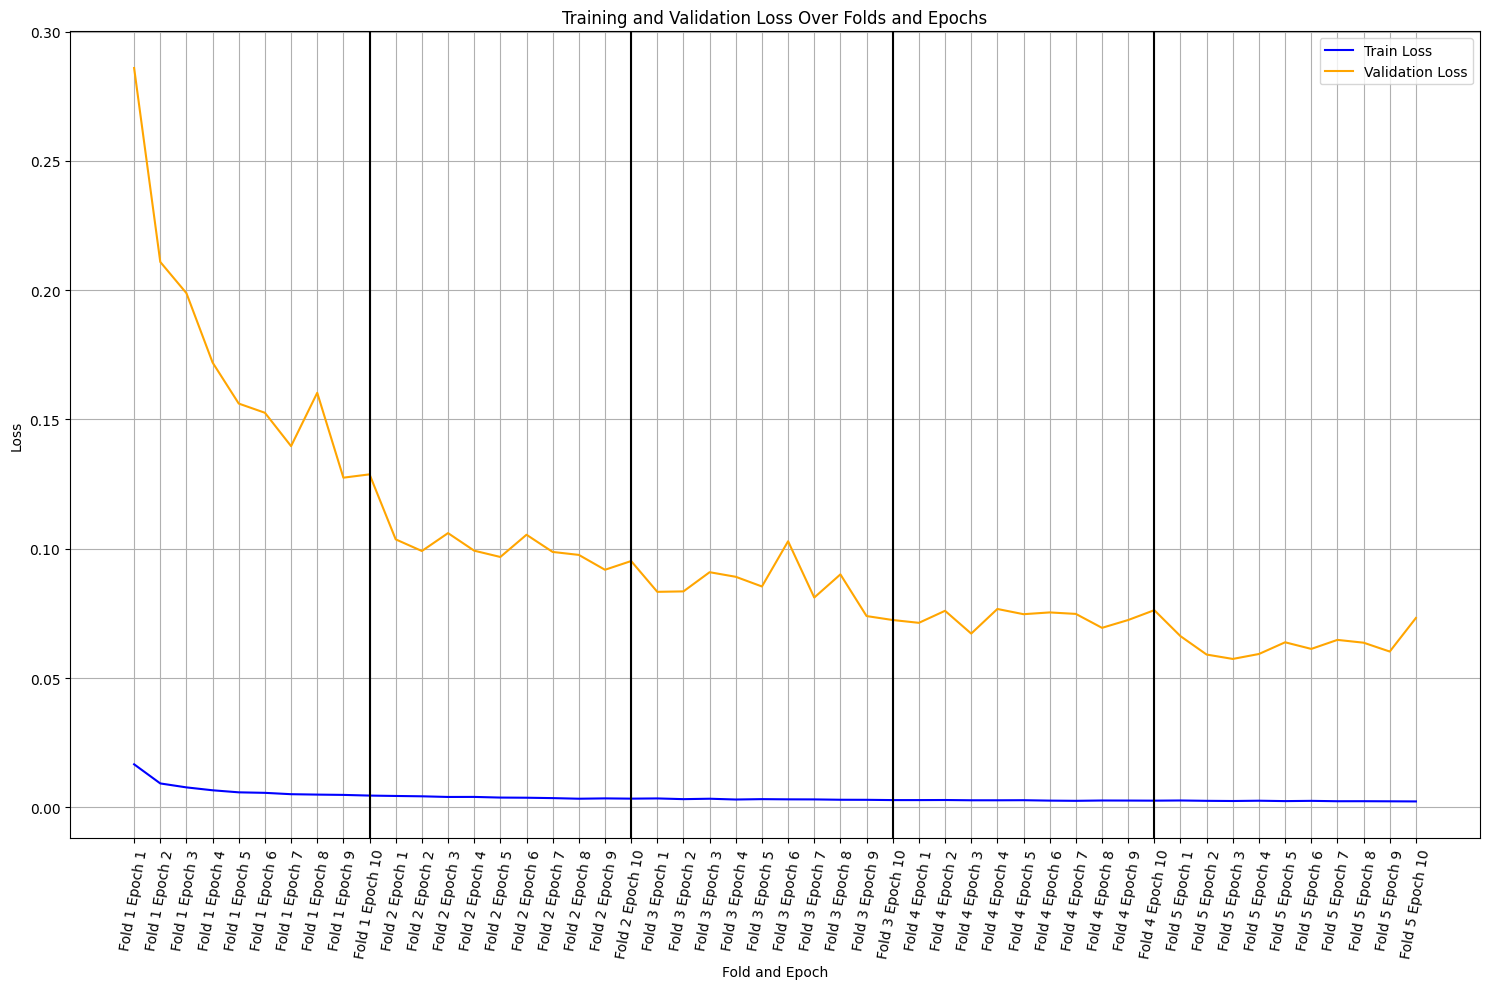

In [25]:
num_folds = 5
num_epochs_per_fold = 10


folds_epochs = []
for fold in range(1, num_folds + 1):
    for epoch in range(1, num_epochs_per_fold + 1):
        folds_epochs.append(f'Fold {fold} Epoch {epoch}')


plt.figure(figsize=(15, 10))
plt.plot(folds_epochs, train_losses, label='Train Loss', color='blue')
plt.plot(folds_epochs, val_losses, label='Validation Loss', color='orange')


for i in range(1, num_folds):
    plt.axvline(x=i * num_epochs_per_fold -1 , color='black', linestyle='-')

plt.xlabel('Fold and Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Folds and Epochs')
plt.xticks(rotation=80)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

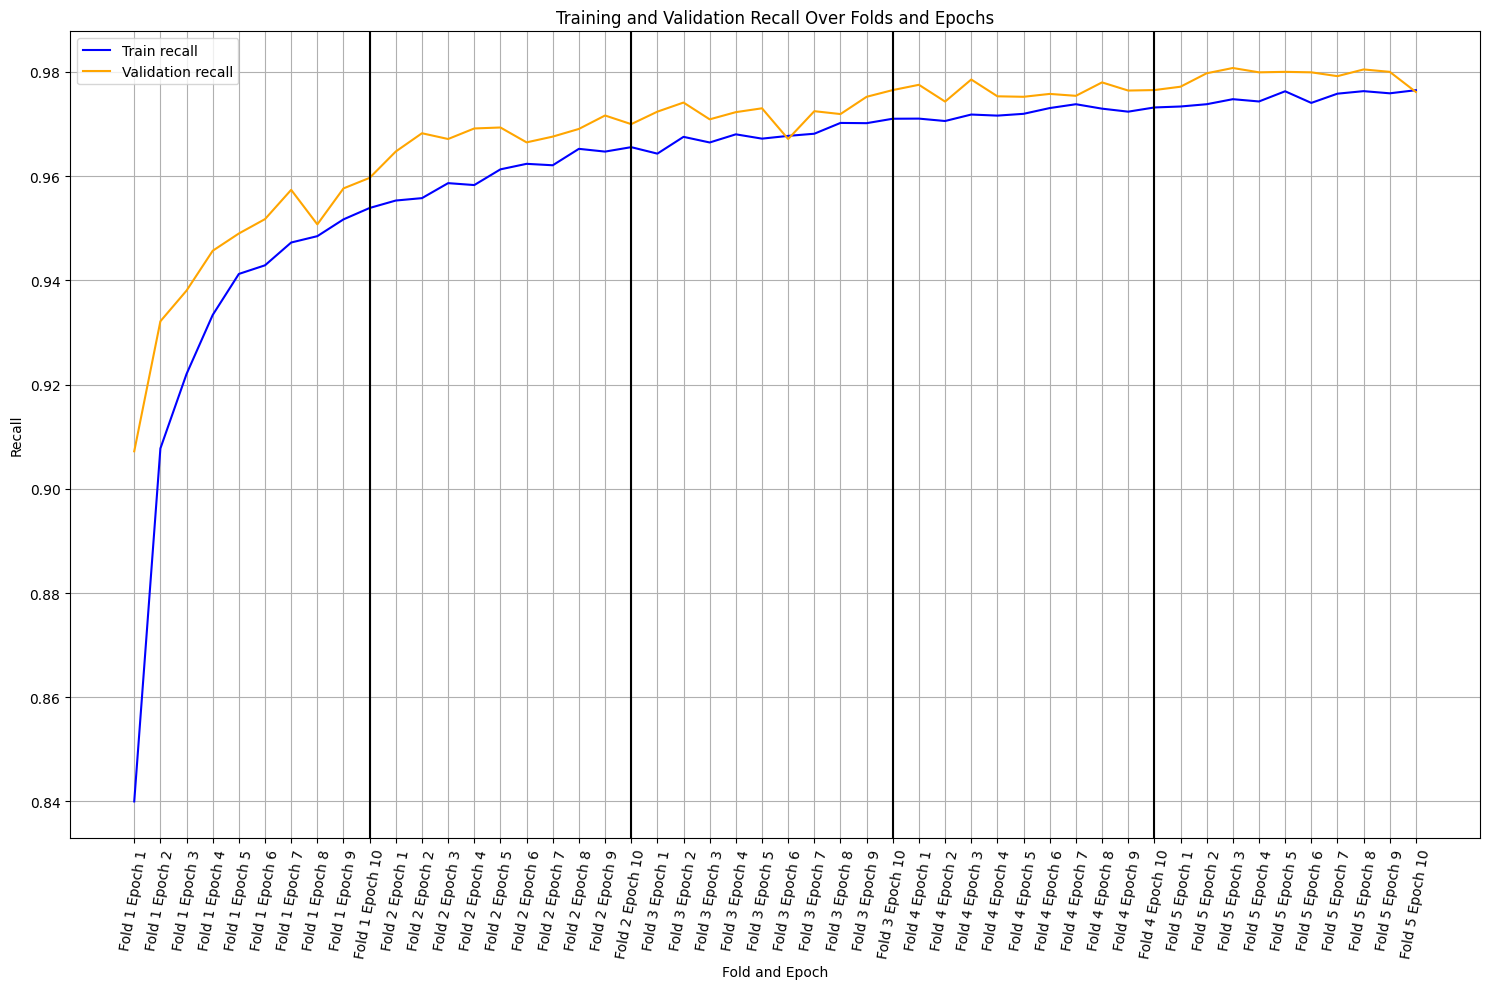

In [26]:
plt.figure(figsize=(15, 10))
plt.plot(folds_epochs, train_recalls, label='Train recall', color='blue')
plt.plot(folds_epochs, val_recalls, label='Validation recall', color='orange')


for i in range(1, num_folds):
    plt.axvline(x=i * num_epochs_per_fold -1 , color='black', linestyle='-')

plt.xlabel('Fold and Epoch')
plt.ylabel('Recall')
plt.title('Training and Validation Recall Over Folds and Epochs')
plt.xticks(rotation=80)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

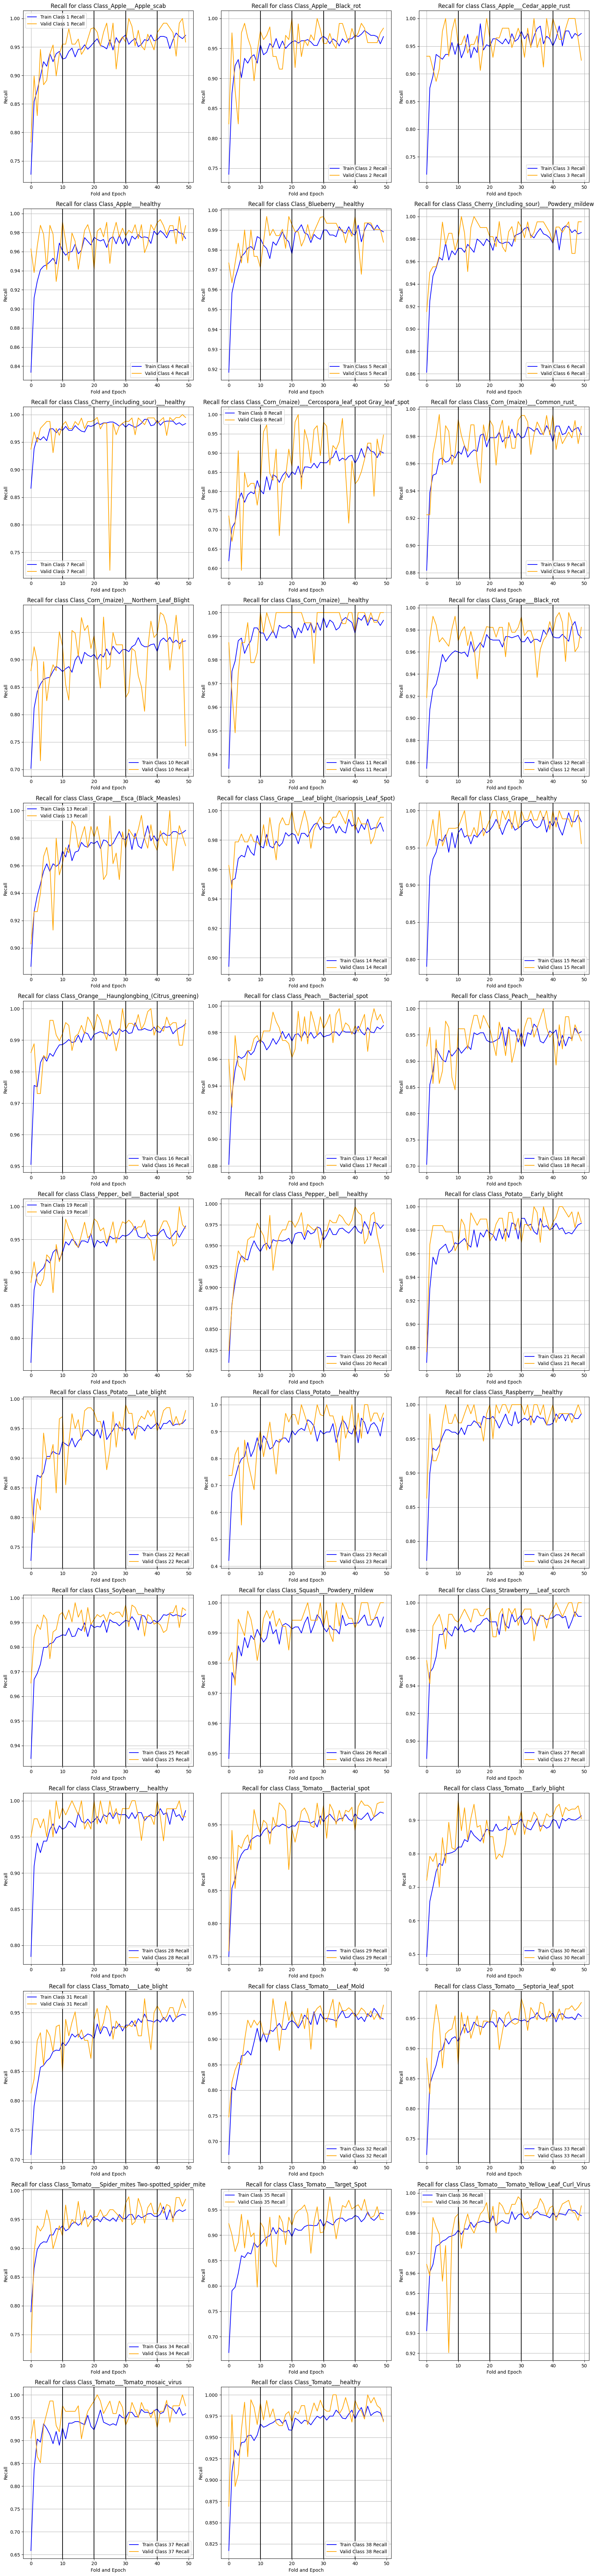

In [27]:
dataset_classes = [f'Class_{class_name}' for class_name in dataset.classes]

# Przygotowanie danych
training_class_recalls = {i: [] for i in range(1, 39)}
for recalls in train_class_recalls:
    for class_idx, recall in enumerate(recalls, start=1):
        training_class_recalls[class_idx].append(recall)

valid_class_recalls = {i: [] for i in range(1, 39)}
for recalls in val_class_recalls:
    for class_idx, recall in enumerate(recalls, start=1):
        valid_class_recalls[class_idx].append(recall)

# Liczba klas
num_classes = 38

# Ustalanie liczby wierszy i kolumn w siatce wykresów
num_cols = 3
num_rows = (num_classes + num_cols - 1) // num_cols

# Tworzenie wykresów
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))
axs = axs.flatten()  # Spłaszczenie tablicy osi dla łatwego iterowania

for class_idx in range(1, num_classes + 1):
    axs[class_idx - 1].plot(training_class_recalls[class_idx], label=f'Train Class {class_idx} Recall', color='blue')
    axs[class_idx - 1].plot(valid_class_recalls[class_idx], label=f'Valid Class {class_idx} Recall', color='orange')

    # Dodawanie pionowych linii oddzielających foldy
    for i in range(1, num_folds):
        axs[class_idx - 1].axvline(x=i * num_epochs_per_fold, color='black', linestyle='-')

    axs[class_idx - 1].set_xlabel('Fold and Epoch')
    axs[class_idx - 1].set_ylabel('Recall')
    axs[class_idx - 1].set_title(f'Recall for class {dataset_classes[class_idx - 1]}')
    axs[class_idx - 1].legend()
    axs[class_idx - 1].grid(True)

# Usuwanie pustych wykresów, jeśli są
for i in range(num_classes, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

Optymalizacja hiperparametrów przy użyciu optymalizacji bayesowskiej

In [28]:
def save_checkpoint_bayes(model, optimizer, trial, fold, epoch, best_loss, train_losses, val_losses, train_recalls, val_recalls, train_class_recalls, val_class_recalls, avg_auc, roc_auc_dict, file_path):
    checkpoint = {
        'trial_number': trial.number,
        'fold': fold,
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_recalls': train_recalls,
        'val_recalls': val_recalls,
        'train_class_recalls': train_class_recalls,
        'val_class_recalls': val_class_recalls,
        'avg_auc': avg_auc,
        'roc_auc_dict': roc_auc_dict,
        'optimizer_name': trial.params['optimizer'],
        'learning_rate': trial.params['learning_rate'],

        'momentum': trial.params.get('momentum'),
        'beta1': trial.params.get('beta1'),
        'beta2': trial.params.get('beta2')
    }
    torch.save(checkpoint, file_path)
    print(f'Checkpoint saved at {file_path}')


In [29]:

def objective(trial):
    momentum = None
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'RMSprop'])
    lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    num_epochs = 10
    batch_size = 32
    if optimizer_name == 'SGD':
        momentum = trial.suggest_uniform('momentum', 0.8, 0.99)

    if optimizer_name == 'Adam':
        beta1 = trial.suggest_uniform('beta1', 0.8, 0.99)
        beta2 = trial.suggest_uniform('beta2', 0.9, 0.999)
    else:
        beta1, beta2 = None, None

    print(f'Trial {trial.number}: Optimizer={optimizer_name}, Learning Rate={lr}, Batch Size={batch_size}, Epochs={num_epochs}')

    if momentum is not None:
        print(f'Momentum={momentum}')
    if beta1 is not None and beta2 is not None:
        print(f'Beta1={beta1}, Beta2={beta2}')


    fold_val_losses = []
    fold_train_losses = []
    fold_train_recalls = []
    fold_val_recalls = []
    fold_train_class_recalls = []
    fold_val_class_recalls = []
    fold_avg_aucs = []
    best_val_loss = float('inf')

    for fold, (train_index, valid_index) in enumerate(kf.split(dataset)):

        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subset = Subset(dataset_transformed, train_index)
        valid_subset = Subset(dataset_transformed, valid_index)

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(valid_subset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)



        if optimizer_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        elif optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, beta2))
        elif optimizer_name == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=lr)

        train_loss, train_recall, train_class_recall = training_loop(model, train_loader, optimizer, criterion)

        val_loss, val_recall, val_class_recall, avg_auc, roc_auc_dict = valid_loop(model, val_loader, criterion)

        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)
        fold_train_recalls.append(train_recall)
        fold_val_recalls.append(val_recall)
        fold_train_class_recalls.append(train_class_recall)
        fold_val_class_recalls.append(val_class_recall)
        fold_avg_aucs.append(avg_auc)



        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = f'/content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_{trial.number}.pt'
            save_checkpoint_bayes(model, optimizer, trial, fold, num_epochs, best_val_loss, fold_train_losses, fold_val_losses, fold_train_recalls, fold_val_recalls, fold_train_class_recalls, fold_val_class_recalls, avg_auc, roc_auc_dict, best_model_path)
            print(f'New best model saved for trial {trial.number}, fold {fold} at epoch {num_epochs} with val_loss {val_loss}')

        avg_val_loss = sum(fold_val_losses) / len(fold_val_losses)
        avg_avg_auc = sum(fold_avg_aucs) / len(fold_avg_aucs)

        print(f'Trial {trial.number} completed with avg_val_loss={avg_val_loss} and avg_avg_auc = {avg_avg_auc}')


        return avg_val_loss

In [38]:

import optuna
os.makedirs('/content/drive/My Drive/Colab Notebooks/checkpoints_bayes', exist_ok=True)

# Uruchomienie optymalizacji z Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f'Best Trial: {study.best_trial.value}')
print(f'Best Parameters: {study.best_trial.params}')

[I 2024-06-09 22:10:16,903] A new study created in memory with name: no-name-ac5921ff-7c05-419a-bdac-73a9c1ecd495


Trial 0: Optimizer=RMSprop, Learning Rate=0.00017693012271399522, Batch Size=32, Epochs=10
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-06-09 22:13:31,226] Trial 0 finished with value: 0.19553570162371375 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.00017693012271399522}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_0.pt
New best model saved for trial 0, fold 0 at epoch 10 with val_loss 0.19553570162371375
Trial 0 completed with avg_val_loss=0.19553570162371375 and avg_avg_auc = 0.9991553673653654
Trial 1: Optimizer=RMSprop, Learning Rate=0.029553274913582908, Batch Size=32, Epochs=10
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-06-09 22:16:48,667] Trial 1 finished with value: 0.49919462007579996 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.029553274913582908}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_1.pt
New best model saved for trial 1, fold 0 at epoch 10 with val_loss 0.49919462007579996
Trial 1 completed with avg_val_loss=0.49919462007579996 and avg_avg_auc = 0.9956321207559705
Trial 2: Optimizer=RMSprop, Learning Rate=0.0026512803976426226, Batch Size=32, Epochs=10
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-06-09 22:20:05,077] Trial 2 finished with value: 0.29659390660235657 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0026512803976426226}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_2.pt
New best model saved for trial 2, fold 0 at epoch 10 with val_loss 0.29659390660235657
Trial 2 completed with avg_val_loss=0.29659390660235657 and avg_avg_auc = 0.997988878931971
Trial 3: Optimizer=Adam, Learning Rate=0.04183220419080651, Batch Size=32, Epochs=10
Beta1=0.8113690287767137, Beta2=0.9689365876694662
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta1 = trial.suggest_uniform('beta1', 0.8, 0.99)
<ipython-input-29-5b41dc1ac955>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta2 = trial.suggest_uniform('beta2', 0.9, 0.999)
[I 2024-06-09 22:23:21,891] Trial 3 finished with value: 0.3571044924945454 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.041832204190806

Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_3.pt
New best model saved for trial 3, fold 0 at epoch 10 with val_loss 0.3571044924945454
Trial 3 completed with avg_val_loss=0.3571044924945454 and avg_avg_auc = 0.9973254755299922
Trial 4: Optimizer=SGD, Learning Rate=0.0008011301063817153, Batch Size=32, Epochs=10
Momentum=0.8517096138330239
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
[I 2024-06-09 22:26:40,760] Trial 4 finished with value: 0.3068218887422357 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.0008011301063817153, 'momentum': 0.8517096138330239}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_4.pt
New best model saved for trial 4, fold 0 at epoch 10 with val_loss 0.3068218887422357
Trial 4 completed with avg_val_loss=0.3068218887422357 and avg_avg_auc = 0.9977521866119646
Trial 5: Optimizer=SGD, Learning Rate=0.010354588101165518, Batch Size=32, Epochs=10
Momentum=0.8390189620240139
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
[I 2024-06-09 22:29:53,241] Trial 5 finished with value: 0.2908880449307617 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.010354588101165518, 'momentum': 0.8390189620240139}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_5.pt
New best model saved for trial 5, fold 0 at epoch 10 with val_loss 0.2908880449307617
Trial 5 completed with avg_val_loss=0.2908880449307617 and avg_avg_auc = 0.9978656721403594
Trial 6: Optimizer=RMSprop, Learning Rate=0.006841504738272129, Batch Size=32, Epochs=10
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-06-09 22:33:10,186] Trial 6 finished with value: 0.24492286322578471 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.006841504738272129}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_6.pt
New best model saved for trial 6, fold 0 at epoch 10 with val_loss 0.24492286322578471
Trial 6 completed with avg_val_loss=0.24492286322578471 and avg_avg_auc = 0.9985149449816914
Trial 7: Optimizer=RMSprop, Learning Rate=0.03173199592268348, Batch Size=32, Epochs=10
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-06-09 22:36:21,867] Trial 7 finished with value: 0.36849098497520627 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.03173199592268348}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_7.pt
New best model saved for trial 7, fold 0 at epoch 10 with val_loss 0.36849098497520627
Trial 7 completed with avg_val_loss=0.36849098497520627 and avg_avg_auc = 0.9974192270670021
Trial 8: Optimizer=RMSprop, Learning Rate=0.08422806809662009, Batch Size=32, Epochs=10
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-06-09 22:39:36,434] Trial 8 finished with value: 0.4195521785715006 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.08422806809662009}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_8.pt
New best model saved for trial 8, fold 0 at epoch 10 with val_loss 0.4195521785715006
Trial 8 completed with avg_val_loss=0.4195521785715006 and avg_avg_auc = 0.9963100113819057
Trial 9: Optimizer=Adam, Learning Rate=0.0057202224573154456, Batch Size=32, Epochs=10
Beta1=0.9599154684575095, Beta2=0.909486133353842
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta1 = trial.suggest_uniform('beta1', 0.8, 0.99)
<ipython-input-29-5b41dc1ac955>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta2 = trial.suggest_uniform('beta2', 0.9, 0.999)
[I 2024-06-09 22:42:52,488] Trial 9 finished with value: 0.28468036186694756 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.00572022245731

Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_9.pt
New best model saved for trial 9, fold 0 at epoch 10 with val_loss 0.28468036186694756
Trial 9 completed with avg_val_loss=0.28468036186694756 and avg_avg_auc = 0.9978741566357945
Trial 10: Optimizer=SGD, Learning Rate=0.00010463260048622247, Batch Size=32, Epochs=10
Momentum=0.9833315398488927
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
[I 2024-06-09 22:46:05,125] Trial 10 finished with value: 0.26291435536270324 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.00010463260048622247, 'momentum': 0.9833315398488927}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_10.pt
New best model saved for trial 10, fold 0 at epoch 10 with val_loss 0.26291435536270324
Trial 10 completed with avg_val_loss=0.26291435536270324 and avg_avg_auc = 0.9982406045750424
Trial 11: Optimizer=RMSprop, Learning Rate=0.00017650951639340188, Batch Size=32, Epochs=10
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-06-09 22:49:19,993] Trial 11 finished with value: 0.2739457508403575 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.00017650951639340188}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_11.pt
New best model saved for trial 11, fold 0 at epoch 10 with val_loss 0.2739457508403575
Trial 11 completed with avg_val_loss=0.2739457508403575 and avg_avg_auc = 0.9980806292988532
Trial 12: Optimizer=RMSprop, Learning Rate=0.0011736494521558713, Batch Size=32, Epochs=10
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-06-09 22:52:31,210] Trial 12 finished with value: 0.2557104858015972 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0011736494521558713}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_12.pt
New best model saved for trial 12, fold 0 at epoch 10 with val_loss 0.2557104858015972
Trial 12 completed with avg_val_loss=0.2557104858015972 and avg_avg_auc = 0.9982861407029572
Trial 13: Optimizer=RMSprop, Learning Rate=0.00033057072507882963, Batch Size=32, Epochs=10
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-06-09 22:55:44,289] Trial 13 finished with value: 0.2470900702813999 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.00033057072507882963}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_13.pt
New best model saved for trial 13, fold 0 at epoch 10 with val_loss 0.2470900702813999
Trial 13 completed with avg_val_loss=0.2470900702813999 and avg_avg_auc = 0.998390955273865
Trial 14: Optimizer=RMSprop, Learning Rate=0.0018110649397633921, Batch Size=32, Epochs=10
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-06-09 22:58:55,989] Trial 14 finished with value: 0.2652385713209857 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0018110649397633921}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_14.pt
New best model saved for trial 14, fold 0 at epoch 10 with val_loss 0.2652385713209857
Trial 14 completed with avg_val_loss=0.2652385713209857 and avg_avg_auc = 0.9981413949898394
Trial 15: Optimizer=Adam, Learning Rate=0.007320331895517289, Batch Size=32, Epochs=10
Beta1=0.8461846221140864, Beta2=0.9980149390354371
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta1 = trial.suggest_uniform('beta1', 0.8, 0.99)
<ipython-input-29-5b41dc1ac955>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta2 = trial.suggest_uniform('beta2', 0.9, 0.999)
[I 2024-06-09 23:02:05,649] Trial 15 finished with value: 0.24980101347686928 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.0073203318955

Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_15.pt
New best model saved for trial 15, fold 0 at epoch 10 with val_loss 0.24980101347686928
Trial 15 completed with avg_val_loss=0.24980101347686928 and avg_avg_auc = 0.9983473249319849
Trial 16: Optimizer=RMSprop, Learning Rate=0.0005558480021189034, Batch Size=32, Epochs=10
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-06-09 23:05:16,824] Trial 16 finished with value: 0.23173207162343554 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0005558480021189034}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_16.pt
New best model saved for trial 16, fold 0 at epoch 10 with val_loss 0.23173207162343554
Trial 16 completed with avg_val_loss=0.23173207162343554 and avg_avg_auc = 0.9985631842683267
Trial 17: Optimizer=RMSprop, Learning Rate=0.00032349103014325277, Batch Size=32, Epochs=10
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-06-09 23:08:25,638] Trial 17 finished with value: 0.2439546295984388 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.00032349103014325277}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_17.pt
New best model saved for trial 17, fold 0 at epoch 10 with val_loss 0.2439546295984388
Trial 17 completed with avg_val_loss=0.2439546295984388 and avg_avg_auc = 0.9984874811649684
Trial 18: Optimizer=Adam, Learning Rate=0.0004891318813227331, Batch Size=32, Epochs=10
Beta1=0.9834753267991893, Beta2=0.9042493461733592
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta1 = trial.suggest_uniform('beta1', 0.8, 0.99)
<ipython-input-29-5b41dc1ac955>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta2 = trial.suggest_uniform('beta2', 0.9, 0.999)
[I 2024-06-09 23:11:38,118] Trial 18 finished with value: 0.2406196063707552 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.00048913188132

Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_18.pt
New best model saved for trial 18, fold 0 at epoch 10 with val_loss 0.2406196063707552
Trial 18 completed with avg_val_loss=0.2406196063707552 and avg_avg_auc = 0.9984734313109206
Trial 19: Optimizer=SGD, Learning Rate=0.0001026155693494412, Batch Size=32, Epochs=10
Momentum=0.957137805304517
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
[I 2024-06-09 23:14:46,104] Trial 19 finished with value: 0.23155236367952858 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.0001026155693494412, 'momentum': 0.957137805304517}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_19.pt
New best model saved for trial 19, fold 0 at epoch 10 with val_loss 0.23155236367952858
Trial 19 completed with avg_val_loss=0.23155236367952858 and avg_avg_auc = 0.9986916636033123
Trial 20: Optimizer=SGD, Learning Rate=0.00012374523349361534, Batch Size=32, Epochs=10
Momentum=0.9597702289291207
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
[I 2024-06-09 23:17:58,690] Trial 20 finished with value: 0.2534096616730548 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.00012374523349361534, 'momentum': 0.9597702289291207}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_20.pt
New best model saved for trial 20, fold 0 at epoch 10 with val_loss 0.2534096616730548
Trial 20 completed with avg_val_loss=0.2534096616730548 and avg_avg_auc = 0.9983165909310298
Trial 21: Optimizer=SGD, Learning Rate=0.00022042192306346344, Batch Size=32, Epochs=10
Momentum=0.921640973409369
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
[I 2024-06-09 23:21:08,451] Trial 21 finished with value: 0.2256012976348061 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.00022042192306346344, 'momentum': 0.921640973409369}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_21.pt
New best model saved for trial 21, fold 0 at epoch 10 with val_loss 0.2256012976348061
Trial 21 completed with avg_val_loss=0.2256012976348061 and avg_avg_auc = 0.998595553091239
Trial 22: Optimizer=SGD, Learning Rate=0.00021873996202192295, Batch Size=32, Epochs=10
Momentum=0.9221557974029122
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
[I 2024-06-09 23:24:19,922] Trial 22 finished with value: 0.2379796068976408 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.00021873996202192295, 'momentum': 0.9221557974029122}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_22.pt
New best model saved for trial 22, fold 0 at epoch 10 with val_loss 0.2379796068976408
Trial 22 completed with avg_val_loss=0.2379796068976408 and avg_avg_auc = 0.9984557113717593
Trial 23: Optimizer=SGD, Learning Rate=0.0002206454739774132, Batch Size=32, Epochs=10
Momentum=0.9134944213335897
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
[I 2024-06-09 23:27:31,320] Trial 23 finished with value: 0.2474227940719763 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.0002206454739774132, 'momentum': 0.9134944213335897}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_23.pt
New best model saved for trial 23, fold 0 at epoch 10 with val_loss 0.2474227940719763
Trial 23 completed with avg_val_loss=0.2474227940719763 and avg_avg_auc = 0.9984765924325906
Trial 24: Optimizer=SGD, Learning Rate=0.00010131275641193699, Batch Size=32, Epochs=10
Momentum=0.9394525502081115
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
[I 2024-06-09 23:30:38,667] Trial 24 finished with value: 0.23238643901653738 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.00010131275641193699, 'momentum': 0.9394525502081115}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_24.pt
New best model saved for trial 24, fold 0 at epoch 10 with val_loss 0.23238643901653738
Trial 24 completed with avg_val_loss=0.23238643901653738 and avg_avg_auc = 0.9986168171787213
Trial 25: Optimizer=SGD, Learning Rate=0.00040492084789239217, Batch Size=32, Epochs=10
Momentum=0.8789267671352736
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
[I 2024-06-09 23:33:49,826] Trial 25 finished with value: 0.23568416776306014 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.00040492084789239217, 'momentum': 0.8789267671352736}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_25.pt
New best model saved for trial 25, fold 0 at epoch 10 with val_loss 0.23568416776306014
Trial 25 completed with avg_val_loss=0.23568416776306014 and avg_avg_auc = 0.9984916842277043
Trial 26: Optimizer=SGD, Learning Rate=0.0008100553050214398, Batch Size=32, Epochs=10
Momentum=0.9887098796466335
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
[I 2024-06-09 23:37:00,938] Trial 26 finished with value: 0.2376720786164001 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.0008100553050214398, 'momentum': 0.9887098796466335}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_26.pt
New best model saved for trial 26, fold 0 at epoch 10 with val_loss 0.2376720786164001
Trial 26 completed with avg_val_loss=0.2376720786164001 and avg_avg_auc = 0.9985351197664203
Trial 27: Optimizer=SGD, Learning Rate=0.00020330874313128798, Batch Size=32, Epochs=10
Momentum=0.8895751821629674
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
[I 2024-06-09 23:40:12,936] Trial 27 finished with value: 0.25082249013419855 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.00020330874313128798, 'momentum': 0.8895751821629674}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_27.pt
New best model saved for trial 27, fold 0 at epoch 10 with val_loss 0.25082249013419855
Trial 27 completed with avg_val_loss=0.25082249013419855 and avg_avg_auc = 0.9983938612180404
Trial 28: Optimizer=SGD, Learning Rate=0.000177429476548654, Batch Size=32, Epochs=10
Momentum=0.9444373404324576
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
[I 2024-06-09 23:43:20,593] Trial 28 finished with value: 0.23902853963432683 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.000177429476548654, 'momentum': 0.9444373404324576}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_28.pt
New best model saved for trial 28, fold 0 at epoch 10 with val_loss 0.23902853963432683
Trial 28 completed with avg_val_loss=0.23902853963432683 and avg_avg_auc = 0.9985381612652684
Trial 29: Optimizer=SGD, Learning Rate=0.001188177889170829, Batch Size=32, Epochs=10
Momentum=0.8115194554581427
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
[I 2024-06-09 23:46:30,859] Trial 29 finished with value: 0.23336761930019265 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.001188177889170829, 'momentum': 0.8115194554581427}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_29.pt
New best model saved for trial 29, fold 0 at epoch 10 with val_loss 0.23336761930019265
Trial 29 completed with avg_val_loss=0.23336761930019265 and avg_avg_auc = 0.9985329216579697
Trial 30: Optimizer=Adam, Learning Rate=0.0002793566533852887, Batch Size=32, Epochs=10
Beta1=0.9089265418055991, Beta2=0.946040680716709
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta1 = trial.suggest_uniform('beta1', 0.8, 0.99)
<ipython-input-29-5b41dc1ac955>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta2 = trial.suggest_uniform('beta2', 0.9, 0.999)
[I 2024-06-09 23:49:43,529] Trial 30 finished with value: 0.2374158960994357 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.00027935665338

Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_30.pt
New best model saved for trial 30, fold 0 at epoch 10 with val_loss 0.2374158960994357
Trial 30 completed with avg_val_loss=0.2374158960994357 and avg_avg_auc = 0.9985458559259391
Trial 31: Optimizer=RMSprop, Learning Rate=0.0005851221123918232, Batch Size=32, Epochs=10
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-06-09 23:52:55,477] Trial 31 finished with value: 0.23889076304439025 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0005851221123918232}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_31.pt
New best model saved for trial 31, fold 0 at epoch 10 with val_loss 0.23889076304439025
Trial 31 completed with avg_val_loss=0.23889076304439025 and avg_avg_auc = 0.9985460784912642
Trial 32: Optimizer=RMSprop, Learning Rate=0.0001331985456612548, Batch Size=32, Epochs=10
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-06-09 23:56:06,806] Trial 32 finished with value: 0.2280723974261946 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0001331985456612548}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_32.pt
New best model saved for trial 32, fold 0 at epoch 10 with val_loss 0.2280723974261946
Trial 32 completed with avg_val_loss=0.2280723974261946 and avg_avg_auc = 0.998664758647988
Trial 33: Optimizer=RMSprop, Learning Rate=0.0001501544381754906, Batch Size=32, Epochs=10
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-06-09 23:59:18,179] Trial 33 finished with value: 0.24971098344779902 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0001501544381754906}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_33.pt
New best model saved for trial 33, fold 0 at epoch 10 with val_loss 0.24971098344779902
Trial 33 completed with avg_val_loss=0.24971098344779902 and avg_avg_auc = 0.9983782803944735
Trial 34: Optimizer=RMSprop, Learning Rate=0.00014013895635509415, Batch Size=32, Epochs=10
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-06-10 00:02:30,081] Trial 34 finished with value: 0.23672815101092376 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.00014013895635509415}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_34.pt
New best model saved for trial 34, fold 0 at epoch 10 with val_loss 0.23672815101092376
Trial 34 completed with avg_val_loss=0.23672815101092376 and avg_avg_auc = 0.9986103459791591
Trial 35: Optimizer=SGD, Learning Rate=0.003219244452055372, Batch Size=32, Epochs=10
Momentum=0.9592895554407025
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
[I 2024-06-10 00:05:38,498] Trial 35 finished with value: 0.23434371049653932 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.003219244452055372, 'momentum': 0.9592895554407025}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_35.pt
New best model saved for trial 35, fold 0 at epoch 10 with val_loss 0.23434371049653932
Trial 35 completed with avg_val_loss=0.23434371049653932 and avg_avg_auc = 0.998573613116332
Trial 36: Optimizer=RMSprop, Learning Rate=0.00032289333054881, Batch Size=32, Epochs=10
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-06-10 00:08:49,888] Trial 36 finished with value: 0.24092402388958042 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.00032289333054881}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_36.pt
New best model saved for trial 36, fold 0 at epoch 10 with val_loss 0.24092402388958042
Trial 36 completed with avg_val_loss=0.24092402388958042 and avg_avg_auc = 0.9985153941501693
Trial 37: Optimizer=SGD, Learning Rate=0.00024170347646413175, Batch Size=32, Epochs=10
Momentum=0.913019162668256
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
[I 2024-06-10 00:11:59,283] Trial 37 finished with value: 0.23979522644555853 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.00024170347646413175, 'momentum': 0.913019162668256}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_37.pt
New best model saved for trial 37, fold 0 at epoch 10 with val_loss 0.23979522644555853
Trial 37 completed with avg_val_loss=0.23979522644555853 and avg_avg_auc = 0.9984962972145617
Trial 38: Optimizer=RMSprop, Learning Rate=0.017204237590622173, Batch Size=32, Epochs=10
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-06-10 00:15:04,245] Trial 38 finished with value: 0.24267673252735916 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.017204237590622173}. Best is trial 0 with value: 0.19553570162371375.


Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_38.pt
New best model saved for trial 38, fold 0 at epoch 10 with val_loss 0.24267673252735916
Trial 38 completed with avg_val_loss=0.24267673252735916 and avg_avg_auc = 0.9986258392526591
Trial 39: Optimizer=Adam, Learning Rate=0.0008006086935439539, Batch Size=32, Epochs=10
Beta1=0.9000023331204392, Beta2=0.9415488752634018
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta1 = trial.suggest_uniform('beta1', 0.8, 0.99)
<ipython-input-29-5b41dc1ac955>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta2 = trial.suggest_uniform('beta2', 0.9, 0.999)
[I 2024-06-10 00:18:16,197] Trial 39 finished with value: 0.23116480855935473 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.0008006086935

Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_39.pt
New best model saved for trial 39, fold 0 at epoch 10 with val_loss 0.23116480855935473
Trial 39 completed with avg_val_loss=0.23116480855935473 and avg_avg_auc = 0.9986303163759589
Trial 40: Optimizer=Adam, Learning Rate=0.0007548797621411116, Batch Size=32, Epochs=10
Beta1=0.8972002020742958, Beta2=0.9373184304071782
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta1 = trial.suggest_uniform('beta1', 0.8, 0.99)
<ipython-input-29-5b41dc1ac955>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta2 = trial.suggest_uniform('beta2', 0.9, 0.999)
[I 2024-06-10 00:21:26,000] Trial 40 finished with value: 0.2207794339313884 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.00075487976214

Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_40.pt
New best model saved for trial 40, fold 0 at epoch 10 with val_loss 0.2207794339313884
Trial 40 completed with avg_val_loss=0.2207794339313884 and avg_avg_auc = 0.9986144413119045
Trial 41: Optimizer=Adam, Learning Rate=0.0008166711374783224, Batch Size=32, Epochs=10
Beta1=0.8971194126240666, Beta2=0.9421936956838586
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta1 = trial.suggest_uniform('beta1', 0.8, 0.99)
<ipython-input-29-5b41dc1ac955>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta2 = trial.suggest_uniform('beta2', 0.9, 0.999)
[I 2024-06-10 00:24:38,303] Trial 41 finished with value: 0.2239802636074006 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.00081667113747

Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_41.pt
New best model saved for trial 41, fold 0 at epoch 10 with val_loss 0.2239802636074006
Trial 41 completed with avg_val_loss=0.2239802636074006 and avg_avg_auc = 0.9986930931881762
Trial 42: Optimizer=Adam, Learning Rate=0.002538508074717011, Batch Size=32, Epochs=10
Beta1=0.8715951946951337, Beta2=0.9288860816972117
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta1 = trial.suggest_uniform('beta1', 0.8, 0.99)
<ipython-input-29-5b41dc1ac955>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta2 = trial.suggest_uniform('beta2', 0.9, 0.999)
[I 2024-06-10 00:27:47,375] Trial 42 finished with value: 0.21877165904036647 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.0025385080747

Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_42.pt
New best model saved for trial 42, fold 0 at epoch 10 with val_loss 0.21877165904036647
Trial 42 completed with avg_val_loss=0.21877165904036647 and avg_avg_auc = 0.9987114868041632
Trial 43: Optimizer=Adam, Learning Rate=0.00319776890439043, Batch Size=32, Epochs=10
Beta1=0.8731751518713147, Beta2=0.9316198587463292
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta1 = trial.suggest_uniform('beta1', 0.8, 0.99)
<ipython-input-29-5b41dc1ac955>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta2 = trial.suggest_uniform('beta2', 0.9, 0.999)
[I 2024-06-10 00:30:55,327] Trial 43 finished with value: 0.22694835294727694 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.0031977689043

Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_43.pt
New best model saved for trial 43, fold 0 at epoch 10 with val_loss 0.22694835294727694
Trial 43 completed with avg_val_loss=0.22694835294727694 and avg_avg_auc = 0.9986869056641537
Trial 44: Optimizer=Adam, Learning Rate=0.0018436990247635984, Batch Size=32, Epochs=10
Beta1=0.9169133374992765, Beta2=0.9287086443733791
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta1 = trial.suggest_uniform('beta1', 0.8, 0.99)
<ipython-input-29-5b41dc1ac955>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta2 = trial.suggest_uniform('beta2', 0.9, 0.999)
[I 2024-06-10 00:34:08,206] Trial 44 finished with value: 0.22013987430588766 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.0018436990247

Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_44.pt
New best model saved for trial 44, fold 0 at epoch 10 with val_loss 0.22013987430588766
Trial 44 completed with avg_val_loss=0.22013987430588766 and avg_avg_auc = 0.998708117304332
Trial 45: Optimizer=Adam, Learning Rate=0.002300609966697437, Batch Size=32, Epochs=10
Beta1=0.9207245225296167, Beta2=0.9254544467228895
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta1 = trial.suggest_uniform('beta1', 0.8, 0.99)
<ipython-input-29-5b41dc1ac955>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta2 = trial.suggest_uniform('beta2', 0.9, 0.999)
[I 2024-06-10 00:37:20,452] Trial 45 finished with value: 0.22136321178587048 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.0023006099666

Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_45.pt
New best model saved for trial 45, fold 0 at epoch 10 with val_loss 0.22136321178587048
Trial 45 completed with avg_val_loss=0.22136321178587048 and avg_avg_auc = 0.9987010037549279
Trial 46: Optimizer=Adam, Learning Rate=0.00198065849716583, Batch Size=32, Epochs=10
Beta1=0.9329430921105919, Beta2=0.9214151563220251
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta1 = trial.suggest_uniform('beta1', 0.8, 0.99)
<ipython-input-29-5b41dc1ac955>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta2 = trial.suggest_uniform('beta2', 0.9, 0.999)
[I 2024-06-10 00:40:30,514] Trial 46 finished with value: 0.2072022838083178 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.00198065849716

Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_46.pt
New best model saved for trial 46, fold 0 at epoch 10 with val_loss 0.2072022838083178
Trial 46 completed with avg_val_loss=0.2072022838083178 and avg_avg_auc = 0.9988254892696259
Trial 47: Optimizer=Adam, Learning Rate=0.002106861741800549, Batch Size=32, Epochs=10
Beta1=0.942278704641458, Beta2=0.9224403809601772
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta1 = trial.suggest_uniform('beta1', 0.8, 0.99)
<ipython-input-29-5b41dc1ac955>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta2 = trial.suggest_uniform('beta2', 0.9, 0.999)
[I 2024-06-10 00:43:43,861] Trial 47 finished with value: 0.2071165735865099 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.00210686174180

Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_47.pt
New best model saved for trial 47, fold 0 at epoch 10 with val_loss 0.2071165735865099
Trial 47 completed with avg_val_loss=0.2071165735865099 and avg_avg_auc = 0.998853669671018
Trial 48: Optimizer=Adam, Learning Rate=0.0038632083148984887, Batch Size=32, Epochs=10
Beta1=0.9403237241687664, Beta2=0.9190589912023143
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta1 = trial.suggest_uniform('beta1', 0.8, 0.99)
<ipython-input-29-5b41dc1ac955>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta2 = trial.suggest_uniform('beta2', 0.9, 0.999)
[I 2024-06-10 00:46:55,308] Trial 48 finished with value: 0.2071310227858382 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.00386320831489

Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_48.pt
New best model saved for trial 48, fold 0 at epoch 10 with val_loss 0.2071310227858382
Trial 48 completed with avg_val_loss=0.2071310227858382 and avg_avg_auc = 0.9989088447963301
Trial 49: Optimizer=Adam, Learning Rate=0.0058775951104687195, Batch Size=32, Epochs=10
Beta1=0.9490009761259186, Beta2=0.9172599917344102
FOLD 0
--------------------------------


<ipython-input-29-5b41dc1ac955>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-29-5b41dc1ac955>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta1 = trial.suggest_uniform('beta1', 0.8, 0.99)
<ipython-input-29-5b41dc1ac955>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta2 = trial.suggest_uniform('beta2', 0.9, 0.999)
[I 2024-06-10 00:50:06,205] Trial 49 finished with value: 0.2155428952697976 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.00587759511046

Checkpoint saved at /content/drive/My Drive/Colab Notebooks/checkpoints_bayes/best_model_trial_49.pt
New best model saved for trial 49, fold 0 at epoch 10 with val_loss 0.2155428952697976
Trial 49 completed with avg_val_loss=0.2155428952697976 and avg_avg_auc = 0.9987971153458066
Best Trial: 0.19553570162371375
Best Parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.00017693012271399522}
